<a href="https://colab.research.google.com/github/1stzl01/CATB0nds/blob/main/Sandbox_proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Expected Loss: $16.19M
Probability of Attachment: 44.02%
Probability of Exhaustion: 23.00%
Gross Premium: $20.23M
Fair Spread: 40.47% of limit
Expected Loss under Climate Stress: $21.07M
Layer 1: XS $100M, Limit $50M
  Expected Loss: $16.19M | Fair Spread: 40.47%
Layer 2: XS $150M, Limit $50M
  Expected Loss: $8.71M | Fair Spread: 21.77%
Layer 3: XS $200M, Limit $100M
  Expected Loss: $7.70M | Fair Spread: 9.62%


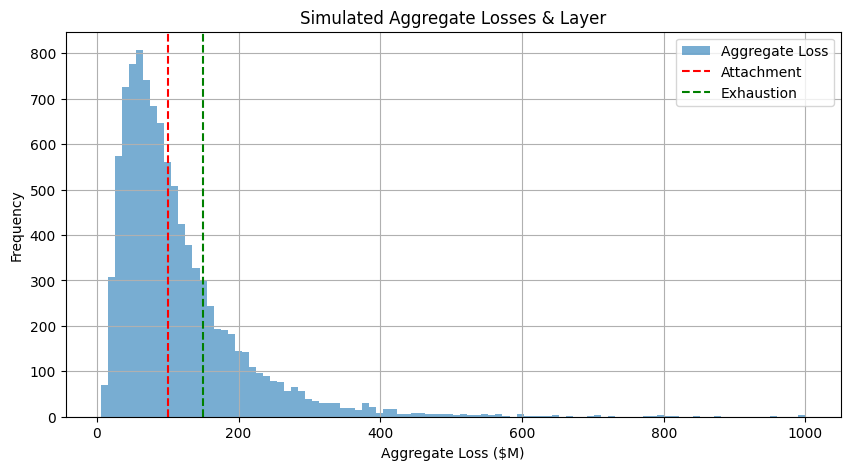

In [ ]:
# --- CAT Bond Pricing POC ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# --- Step 1: Simulate Aggregate Catastrophe Losses ---
np.random.seed(42)
n_years = 10000
losses = np.random.lognormal(mean=4.5, sigma=0.7, size=n_years)
losses = np.clip(losses, 0, 1000)

df = pd.DataFrame({'year': range(1, n_years + 1), 'agg_loss': losses})

# --- Step 2: Define CAT Bond Layer ---
attachment = 100  # XS $100M
limit = 50        # $50M limit

def calc_payout(loss, att, lim):
    return max(min(loss - att, lim), 0)

df['payout'] = df['agg_loss'].apply(lambda x: calc_payout(x, attachment, limit))

# --- Step 3: Compute Pricing Metrics ---
expected_loss = df['payout'].mean()
p_attach = np.mean(df['agg_loss'] > attachment)
p_exhaust = np.mean(df['agg_loss'] > (attachment + limit))
risk_load = 0.25
gross_premium = expected_loss * (1 + risk_load)
fair_spread = gross_premium / limit

print(f"Expected Loss: ${expected_loss:.2f}M")
print(f"Probability of Attachment: {p_attach:.2%}")
print(f"Probability of Exhaustion: {p_exhaust:.2%}")
print(f"Gross Premium: ${gross_premium:.2f}M")
print(f"Fair Spread: {fair_spread:.2%} of limit")

# --- Step 4: Climate Stress Scenario (+20% Severity) ---
climate_multiplier = 1.2
df['agg_loss_climate'] = df['agg_loss'] * climate_multiplier
df['payout_climate'] = df['agg_loss_climate'].apply(lambda x: calc_payout(x, attachment, limit))

el_climate = df['payout_climate'].mean()
print(f"Expected Loss under Climate Stress: ${el_climate:.2f}M")

# --- Step 5: Price Multiple Tranches ---
layers = [
    {'att': 100, 'lim': 50},
    {'att': 150, 'lim': 50},
    {'att': 200, 'lim': 100},
]

for i, layer in enumerate(layers):
    df[f'payout_layer_{i+1}'] = df['agg_loss'].apply(lambda x: calc_payout(x, layer['att'], layer['lim']))
    el = df[f'payout_layer_{i+1}'].mean()
    spread = el * 1.25 / layer['lim']
    print(f"Layer {i+1}: XS ${layer['att']}M, Limit ${layer['lim']}M")
    print(f"  Expected Loss: ${el:.2f}M | Fair Spread: {spread:.2%}")

# --- Step 6: Visualize Loss Distribution and Layer ---
plt.figure(figsize=(10, 5))
plt.hist(df['agg_loss'], bins=100, alpha=0.6, label='Aggregate Loss')
plt.axvline(attachment, color='red', linestyle='--', label='Attachment')
plt.axvline(attachment + limit, color='green', linestyle='--', label='Exhaustion')
plt.title('Simulated Aggregate Losses & Layer')
plt.xlabel('Aggregate Loss ($M)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()